In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.utils import resample
import os

In [ ]:
# Montamos la unidad de drive y trabajamos con los datasets y modelos preparados de forma persistente
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Proceso de conexión a Kaggle, descarga y descompresión del dataset en ZIP
# Sólo la primera vez
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

In [ ]:
#!unzip /content/drive/MyDrive/cbis-ddsm-breast-cancer-image-dataset.zip -d /content/drive/MyDrive/cbis-ddsm
#!mv /content/cbis-ddsm-breast-cancer-image-dataset.zip /content/drive/MyDrive/

In [ ]:
datasetdir = '/content/drive/MyDrive/cbis-ddsm'
df = pd.read_csv(f'{datasetdir}/csv/dicom_info.csv')
# Preparamos la ruta completa teniendo en cuenta la unidad de persistencia en drive
df['image_path'] = df.image_path.apply(lambda x: x.replace('CBIS-DDSM', datasetdir))
#df.head()

In [ ]:
df[['image_path','SeriesDescription','PatientID','SeriesInstanceUID']].head()

,image_path,SeriesDescription,PatientID,SeriesInstanceUID
0,/content/drive/MyDrive/cbis-ddsm/jpeg/1.3.6.1....,cropped images,Mass-Training_P_01265_RIGHT_MLO_1,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...
1,/content/drive/MyDrive/cbis-ddsm/jpeg/1.3.6.1....,full mammogram images,Mass-Training_P_01754_RIGHT_CC,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...
2,/content/drive/MyDrive/cbis-ddsm/jpeg/1.3.6.1....,full mammogram images,Calc-Training_P_00232_RIGHT_CC,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...
3,/content/drive/MyDrive/cbis-ddsm/jpeg/1.3.6.1....,cropped images,Calc-Test_P_00562_LEFT_CC_2,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...
4,/content/drive/MyDrive/cbis-ddsm/jpeg/1.3.6.1....,NaN,P_00562_LEFT_CC_2.dcm,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...


In [ ]:
print(df.SeriesDescription.unique())
print(df['SeriesDescription'].value_counts())

['cropped images' 'full mammogram images' nan 'ROI mask images']
SeriesDescription
cropped images           3567
ROI mask images          3247
full mammogram images    2857
Name: count, dtype: int64


In [ ]:
print(df['SeriesDescription'].isna().sum())

566


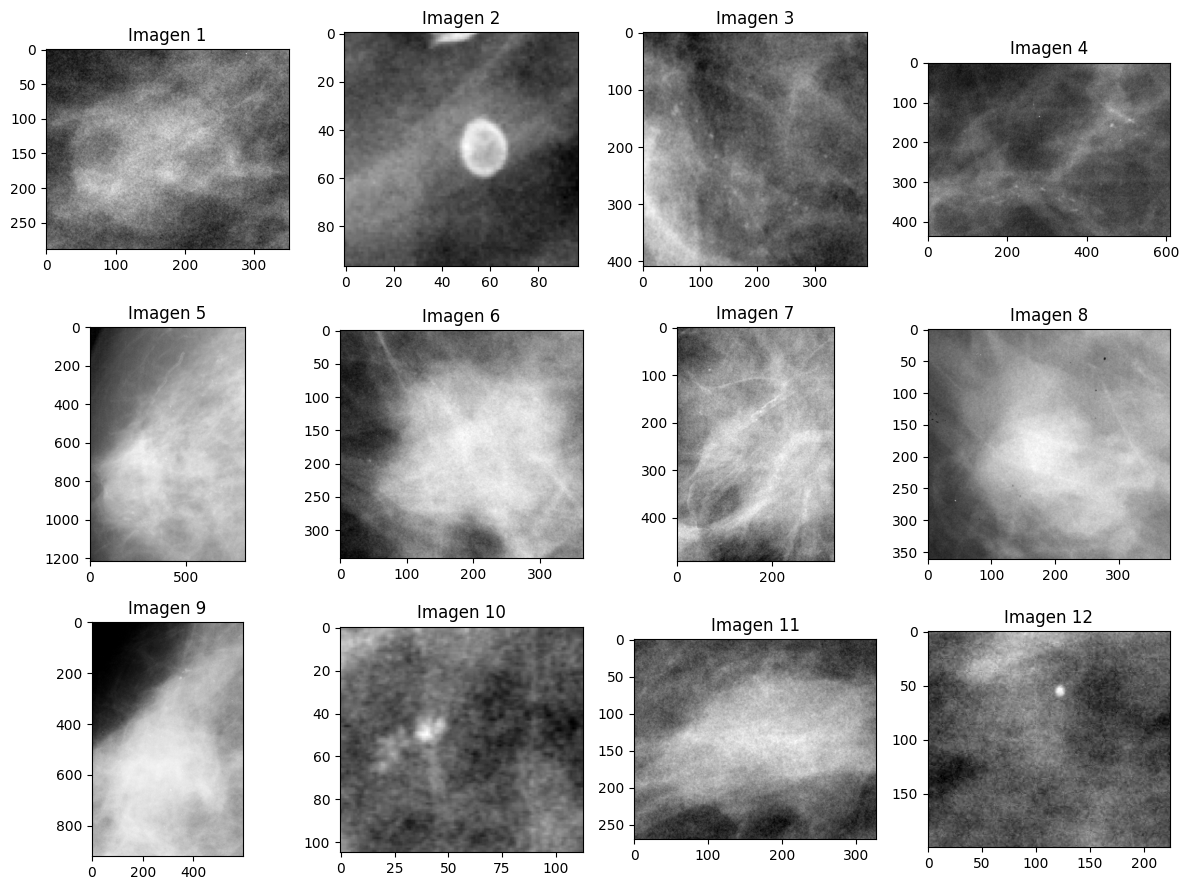

In [ ]:
def mostrar_imagenes_malla(rutas_imagenes, filas, columnas):
    fig = plt.figure(figsize=(columnas*3, filas*3))

    gs = gridspec.GridSpec(filas, columnas)

    for i, ruta_imagen in enumerate(rutas_imagenes):
        ax = fig.add_subplot(gs[i])
        imagen = mpimg.imread(ruta_imagen)
        ax.imshow(imagen, cmap='gray')
        ax.axis('on')
        ax.set_title(f'Imagen {i+1}')

    plt.tight_layout()
    plt.show()

imagenes_cropped = df[df.SeriesDescription=='cropped images'].image_path.tolist()[:12]
imagenes_full = df[df.SeriesDescription=='full mammogram images'].image_path.tolist()[:12]
imagenes_ROI = df[df.SeriesDescription=='ROI mask images'].image_path.tolist()[:12]
imagenes_NaN = df[df.SeriesDescription.isna()].image_path.tolist()[:12]

filas = 3
columnas = 4
mostrar_imagenes_malla(imagenes_cropped, filas, columnas)

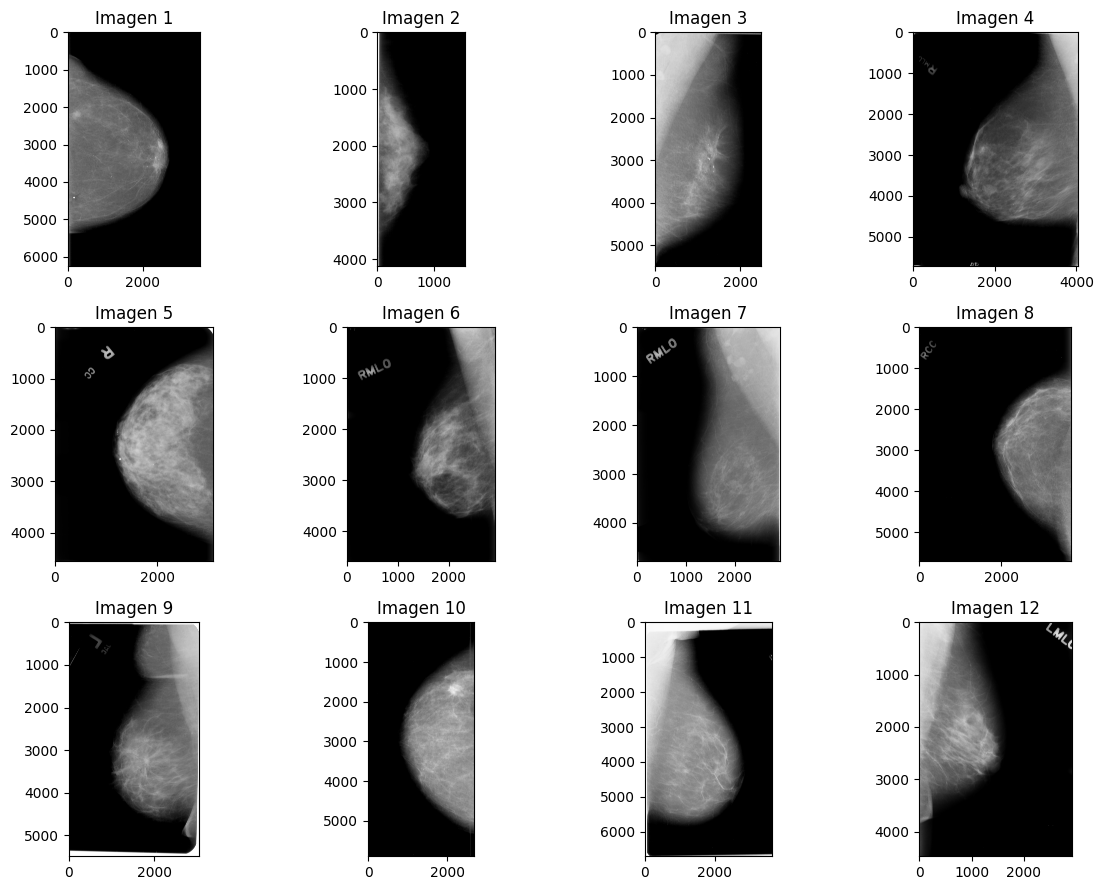

In [ ]:
mostrar_imagenes_malla(imagenes_full, filas, columnas)

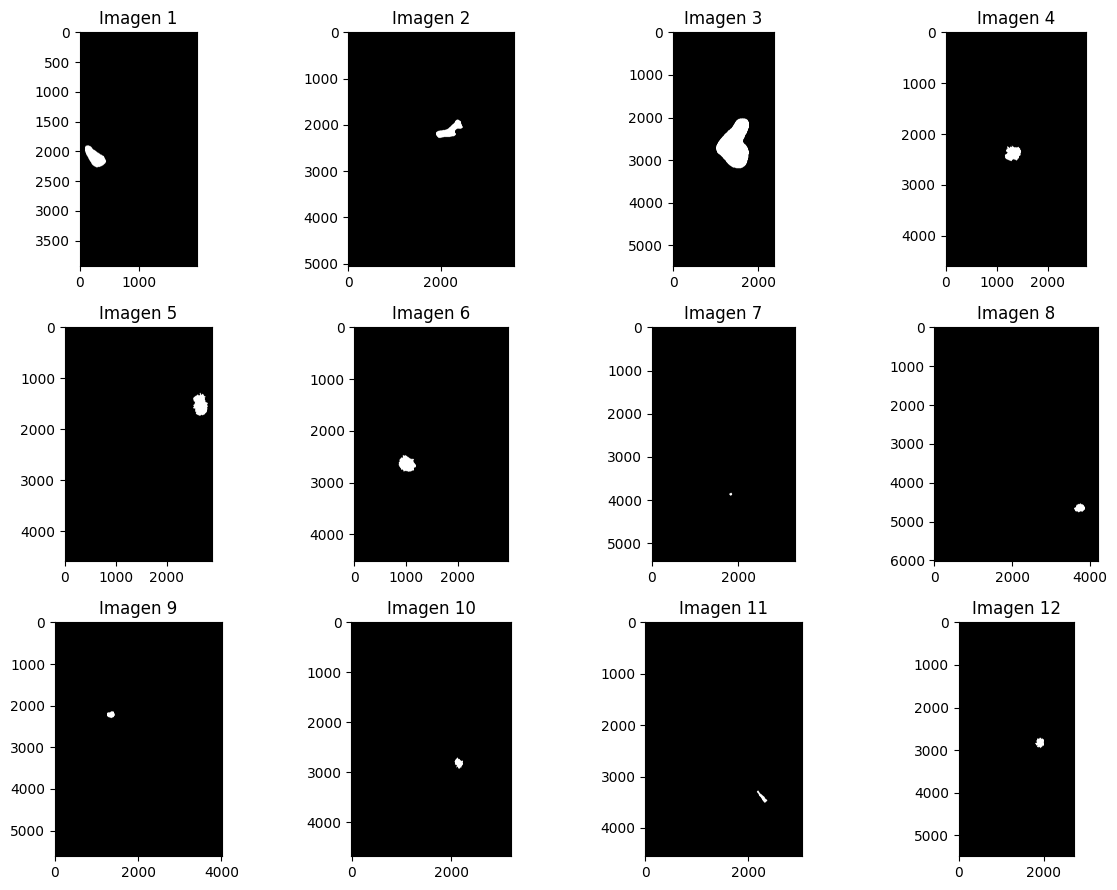

In [ ]:
mostrar_imagenes_malla(imagenes_ROI, filas, columnas)

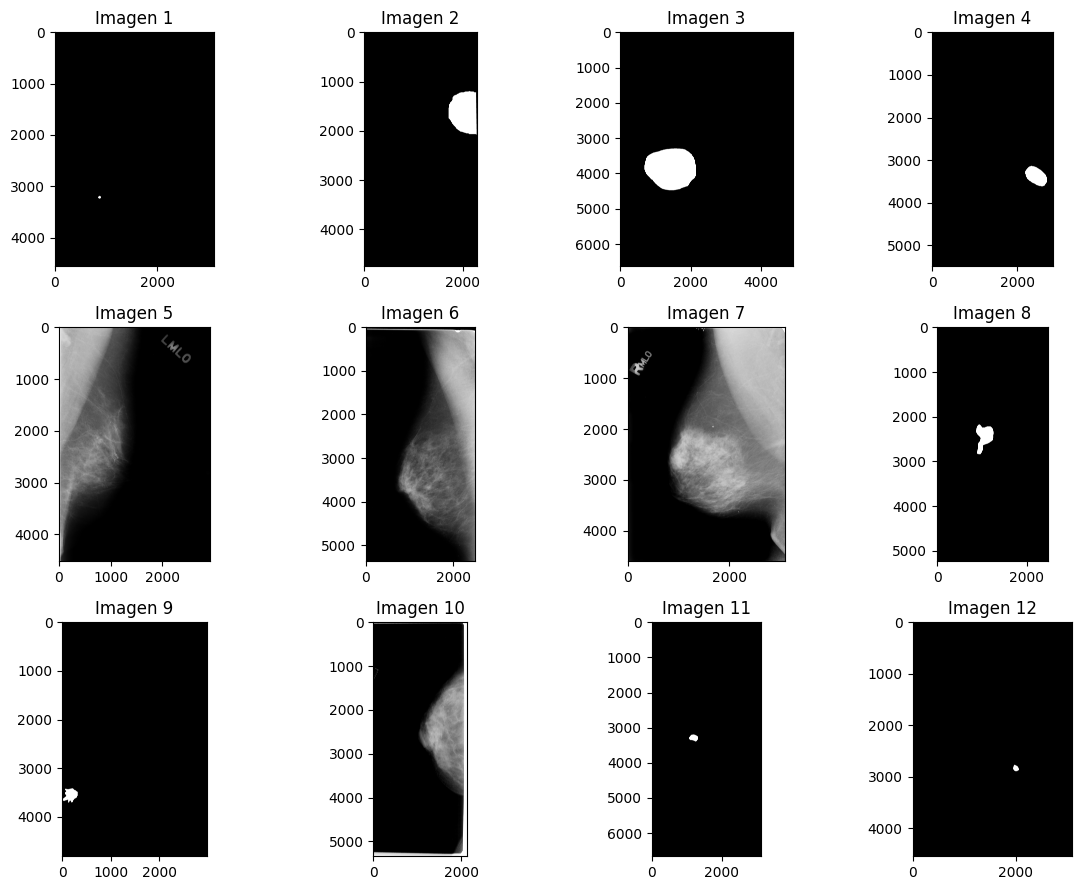

In [ ]:
mostrar_imagenes_malla(imagenes_NaN, filas, columnas)

Las imágenes "NaN" no están bien clasificadas, y no se tendrán en cuenta en el trabajo. Tampoco usaremos las "ROI" al tratarse de imágenes para segmentación, aspecto que no trabajaremos en este estudio.
Dado que el objetivo de este trabajo consiste en abordar la problemática de clasificación mediante mamografías normales, descartaremos las cropped images que vienen ya preparadas en un preproceso previo del dataset.
Trabajaremos únicamente con las "full images".

In [ ]:
print(df.Columns.unique())
print(df.Rows.unique())

[ 351 3526 1546 ... 1209  656 1297]
[ 289 6256 4126 ...  499 1281  772]


In [ ]:
df = df.drop(df[df['SeriesDescription'].isna()].index)
df = df.drop(df[df['SeriesDescription']=='ROI mask images'].index)
print(df['SeriesDescription'].value_counts())

SeriesDescription
cropped images           3567
full mammogram images    2857
Name: count, dtype: int64


In [ ]:
# Preparación del dataset para extraer imágenes de tipo "masa" del conjunto de entrenamiento
df_mass_train = pd.read_csv(f'{datasetdir}/csv/mass_case_description_train_set.csv')
df_mass_train = df_mass_train.rename(columns={'image file path':'image_file_path'})
df_mass_train['image_file_path_studyInstanceUID'] = df_mass_train.image_file_path.str.split("/",expand=True,)[1]
full_images = df[df.SeriesDescription == 'full mammogram images']
df_mass_train['full_image_path'] = pd.merge(df_mass_train, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_mass_train.loc[df_mass_train.pathology=='BENIGN_WITHOUT_CALLBACK','pathology']='BENIGN'
print(df_mass_train['pathology'].value_counts())

pathology
BENIGN       681
MALIGNANT    637
Name: count, dtype: int64


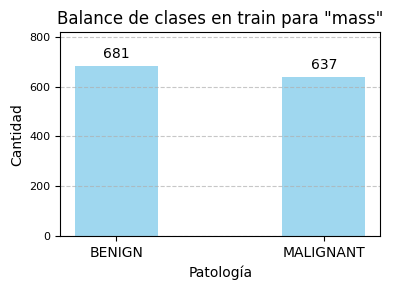

In [ ]:
frecuencias = df_mass_train['pathology'].value_counts()
valores = frecuencias.index.tolist()
frecuencias = frecuencias.tolist()

plt.figure(figsize=(4, 3))
bars = plt.bar(valores, frecuencias, width=0.4, color='skyblue', alpha=0.8)
plt.ylim(0, max(frecuencias) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(frecuencias) * 0.03, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Balance de clases en train para "mass"', fontsize=12)
plt.xlabel('Patología', fontsize=10)
plt.ylabel('Cantidad', fontsize=10)
plt.xticks(valores, fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Preparación del dataset para extraer imágenes de tipo "calcificacion" del conjunto de entrenamiento
df_calc_train = pd.read_csv(f'{datasetdir}/csv/calc_case_description_train_set.csv')
df_calc_train = df_calc_train.rename(columns={'image file path':'image_file_path'})
df_calc_train = df_calc_train.rename(columns={'cropped image file path':'cropped_image_file_path'})
df_calc_train['image_file_path_studyInstanceUID'] = df_calc_train.image_file_path.str.split("/",expand=True,)[1]
full_images=df[df.SeriesDescription == 'full mammogram images']
df_calc_train['full_image_path']=pd.merge(df_calc_train, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_calc_train.loc[df_calc_train.pathology=='BENIGN_WITHOUT_CALLBACK','pathology']='BENIGN'
print(df_calc_train['pathology'].value_counts())

pathology
BENIGN       1002
MALIGNANT     544
Name: count, dtype: int64


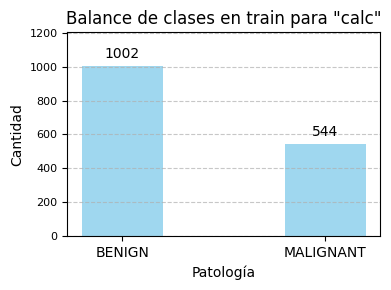

In [ ]:
frecuencias = df_calc_train['pathology'].value_counts()
valores = frecuencias.index.tolist()
frecuencias = frecuencias.tolist()

plt.figure(figsize=(4, 3))
bars = plt.bar(valores, frecuencias, width=0.4, color='skyblue', alpha=0.8)
plt.ylim(0, max(frecuencias) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(frecuencias) * 0.03, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Balance de clases en train para "calc"', fontsize=12)
plt.xlabel('Patología', fontsize=10)
plt.ylabel('Cantidad', fontsize=10)
plt.xticks(valores, fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Observamos que la clase "MALIGNANT" está a la mitad de muestras, por lo que tenemos el dataset desbalanceado. Aplicaremos la técnica de oversampling para aumentar la cantidad de muestras al cargar las imágenes originales a nuestro tensor.

In [ ]:
# Preparación del dataset para extraer imágenes de tipo "masa" del conjunto de validación
df_mass_test = pd.read_csv(f'{datasetdir}/csv/mass_case_description_test_set.csv')
df_mass_test = df_mass_test.rename(columns={'image file path':'image_file_path'})
df_mass_test['image_file_path_studyInstanceUID'] = df_mass_test.image_file_path.str.split("/",expand=True,)[1]
full_images=df[df.SeriesDescription == 'full mammogram images']
df_mass_test['full_image_path']=pd.merge(df_mass_test, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_mass_test.loc[df_mass_test.pathology=='BENIGN_WITHOUT_CALLBACK','pathology']='BENIGN'
print(df_mass_test['pathology'].value_counts())

pathology
BENIGN       231
MALIGNANT    147
Name: count, dtype: int64


In [ ]:
# Preparación del dataset para extraer imágenes de tipo "calcificacion" del conjunto de validación
df_calc_test = pd.read_csv(f'{datasetdir}/csv/calc_case_description_test_set.csv')
df_calc_test = df_calc_test.rename(columns={'image file path':'image_file_path'})
df_calc_test['image_file_path_studyInstanceUID'] = df_calc_test.image_file_path.str.split("/",expand=True,)[1]
full_images=df[df.SeriesDescription == 'full mammogram images']
df_calc_test['full_image_path']=pd.merge(df_calc_test, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_calc_test.loc[df_calc_test.pathology=='BENIGN_WITHOUT_CALLBACK','pathology']='BENIGN'
print(df_calc_test['pathology'].value_counts())

# Eliminar algunos nulos detectados en la ruta
df_calc_test = df_calc_test.dropna(subset=['full_image_path'])

pathology
BENIGN       197
MALIGNANT    129
Name: count, dtype: int64


In [ ]:
# Verificar que no hay nulos en la rutas
df_mass_test['full_image_path'].isnull().sum()

In [ ]:
# Proceso de carga y transformaciones básicas desde JPG a tensores
X_train = []
y_train = []

filas = 224
columnas = 224
contador = 1

preprocess = transforms.Compose([
    transforms.Resize((filas, columnas)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

for i in range(len(df_mass_train)):
    image_path = os.path.join(df_mass_train.loc[i, 'full_image_path'])
    img = Image.open(image_path)
    img_tensor = preprocess(img)

    X_train.append(img_tensor)
    y_train.append(0 if df_mass_train.loc[i, 'pathology'] == 'BENIGN' else 1)

    if contador % 100 == 0:
        print(f'Imagen {contador} cargada')
    contador = contador + 1

for i in range(len(df_calc_train)):
    image_path = os.path.join(df_calc_train.loc[i, 'full_image_path'])
    img = Image.open(image_path)
    img_tensor = preprocess(img)

    X_train.append(img_tensor)
    y_train.append(0 if df_calc_train.loc[i, 'pathology'] == 'BENIGN' else 1)

    if contador % 100 == 0:
        print(f'Imagen {contador} cargada')
    contador = contador + 1

X_train_tensor = torch.stack(X_train)
y_train_tensor = torch.tensor(y_train)

In [ ]:
X_train_tensor.shape

torch.Size([2864, 1, 224, 224])

In [ ]:
y_train_tensor.shape

torch.Size([2864])

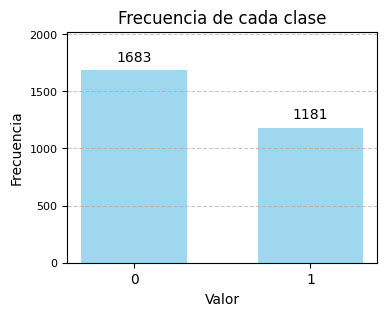

In [ ]:
valores_unicos, indices = torch.unique(y_train_tensor, return_inverse=True)
frecuencias = torch.bincount(indices)

valores = valores_unicos.tolist()
frecuencias = frecuencias.tolist()

plt.figure(figsize=(4, 3))
bars = plt.bar(valores, frecuencias, width=0.6, color='skyblue', alpha=0.8)

plt.ylim(0, max(frecuencias) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(frecuencias) * 0.03, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Frecuencia de cada clase', fontsize=12)
plt.xlabel('Valor', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(valores, fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# Oversampling de la clase minoritaria para train
X_clase_0 = X_train_tensor[y_train_tensor == 0]
X_clase_1 = X_train_tensor[y_train_tensor == 1]

X_clase_1_oversampled = resample(X_clase_1, replace=True, n_samples=len(X_clase_0), random_state=42)

X_train_balanced = torch.cat([X_clase_0, X_clase_1_oversampled])

y_train_balanced = torch.cat([torch.zeros(len(X_clase_0)), torch.ones(len(X_clase_0))]).long()

# Verificar resultado del oversampling
print("Balance de clases después del oversampling:")
print("Clase 0:", (y_train_balanced == 0).sum().item())
print("Clase 1:", (y_train_balanced == 1).sum().item())

Balance de clases después del oversampling:
Clase 0: 1683
Clase 1: 1683


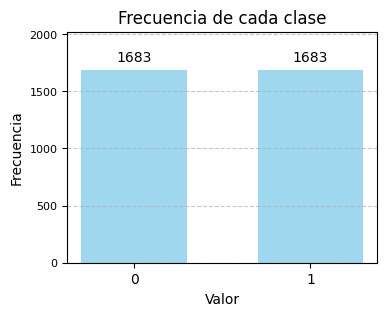

In [ ]:
valores_unicos, indices = torch.unique(y_train_balanced, return_inverse=True)
frecuencias = torch.bincount(indices)

valores = valores_unicos.tolist()
frecuencias = frecuencias.tolist()

plt.figure(figsize=(4, 3))
bars = plt.bar(valores, frecuencias, width=0.6, color='skyblue', alpha=0.8)

plt.ylim(0, max(frecuencias) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(frecuencias) * 0.03, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Frecuencia de cada clase', fontsize=12)
plt.xlabel('Valor', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(valores, fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# Almacenamiento de los tensores de entrenamiento para poder utilizarlos cómodamente en cada sesión
torch.save(X_train_balanced, datasetdir + "/X_train_balanced.pt")
torch.save(y_train_balanced, datasetdir + "/y_train_balanced.pt")

In [ ]:
# Carga de imágenes de validación al tensor, en este caso no aplicaremos oversampling
X_test = []
y_test = []

filas = 224
columnas = 224
contador = 1

preprocess = transforms.Compose([
    transforms.Resize((filas, columnas)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

for i in range(len(df_mass_test)):
    image_path = os.path.join(df_mass_test.loc[i, 'full_image_path'])
    img = Image.open(image_path)
    img_tensor = preprocess(img)

    X_test.append(img_tensor)
    y_test.append(0 if df_mass_test.loc[i, 'pathology'] == 'BENIGN' else 1)

    if contador % 100 == 0:
        print(f'Imagen {contador} cargada')
    contador = contador + 1

for i in range(len(df_calc_test)):
    image_path = os.path.join(df_calc_test.loc[i, 'full_image_path'])
    img = Image.open(image_path)
    img_tensor = preprocess(img)

    X_test.append(img_tensor)
    y_test.append(0 if df_calc_test.loc[i, 'pathology'] == 'BENIGN' else 1)

    if contador % 100 == 0:
        print(f'Imagen {contador} cargada')
    contador = contador + 1

X_test_tensor = torch.stack(X_test)
y_test_tensor = torch.tensor(y_test)

In [ ]:
# Almacenamiento de tensores de validación
torch.save(X_test_tensor, datasetdir + "/X_test.pt")
torch.save(y_test_tensor, datasetdir + "/y_test.pt")

In [ ]:
print('X train shape : {}' .format(X_train.shape))
print('y train shape : {}' .format(y_train.shape))
print('X test shape : {}' .format(X_test.shape))
print('y test shape : {}' .format(y_test.shape))